In [2]:
import ROOT
import os
import time
import matplotlib.pyplot as plt
import csv

Welcome to JupyROOT 6.24/06


In [3]:
path = "../merged/"

In [4]:
def get_total_size(path, num_files):
    filenames = sorted(os.listdir(path))
    total_size = sum([os.path.getsize(path + filenames[i]) for i in range(num_files)])
    return total_size / (2**30)

In [5]:
def col_average(data):
    n_rows = len(data)
    n_cols = len(data[0])
    return [sum([data[i][j] for i in range(1, n_rows)]) / (n_rows - 1) for j in range(n_cols)]

In [6]:
def runtime_measure(path, num_files, num_threads):
    # Specify the number of threads
    ROOT.ROOT.EnableImplicitMT(num_threads)
    
    # Get paths to all the files to be read 
    filenames = sorted(os.listdir(path))
    files_to_read = ROOT.std.vector('string')()
    for i in range(num_files):
        files_to_read.push_back(path + filenames[i])
    
    # Measure runtime
    start_time = time.time()
    data = ROOT.RDataFrame("rootuple/CandidateTree", files_to_read)
    cut = data.Filter("candidate_charge == 0")\
          .Filter("candidate_cosAlpha > 0.99")\
          .Filter("candidate_vProb > 0.05")\
          .Filter("candidate_lxy / candidate_lxyErr > 3.0")\
          .Filter("ditrack_mass > 1.014")\
          .Filter("ditrack_mass < 1.024")\
          .Filter("candidate_vMass > 5.33")\
          .Filter("candidate_vMass < 5.40")
    np_array = cut.AsNumpy(["candidate_vMass"])
    runtime = time.time() - start_time
    
    return runtime
    

In [7]:
def runtime_vs_size(path, num_threads, max_files, step, num_loops):
    x = [get_total_size(path, a) for a in range(step, max_files + step, step)]
    with open("runtime_tests/runtime_vs_size_%d_%d_%d_%d.csv" % (num_threads, max_files, step, num_loops), "w+", newline="") as f:
        csv.writer(f).writerow(x)
    for n in range(num_loops):
        y = [runtime_measure(path, i, num_threads) for i in range(step, max_files + step, step)]
        with open("runtime_tests/runtime_vs_size_%d_%d_%d_%d.csv" % (num_threads, max_files, step, num_loops), "a+", newline="") as f:
            csv.writer(f).writerow(y)


In [8]:
def runtime_vs_size_plot(path, num_threads, max_files, step, num_loops):
    if not os.path.exists("runtime_tests/runtime_vs_size_%d_%d_%d_%d.csv" % (num_threads, max_files, step, num_loops)):
        runtime_vs_size(path, num_threads, max_files, step, num_loops)
    with open("runtime_tests/runtime_vs_size_%d_%d_%d_%d.csv" % (num_threads, max_files, step, num_loops), "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        plt.figure(figsize = (15, 5))
        plt.title('Runtime vs Size (%d threads)' % (num_threads))
        plt.xlabel('Size (GB)')
        plt.ylabel('Runtime (s)')
        plt.savefig('figures/runtime_vs_size_%d_%d_%d_%d.png' % (num_threads, max_files, step, num_loops), bbox_inches='tight')
        plt.scatter(data[0], col_average(data))

In [9]:
def runtime_vs_threads(path, num_files, max_threads, step, num_loops):
    x = [a for a in range(step, max_threads + step, step)]
    with open("runtime_tests/runtime_vs_threads_%d_%d_%d_%d.csv" % (num_files, max_threads, step, num_loops), "w+", newline="") as f:
        csv.writer(f).writerow(x)
    for n in range(num_loops):
        y = [runtime_measure(path, num_files, i) for i in range(step, max_threads + step, step)]
        with open("runtime_tests/runtime_vs_threads_%d_%d_%d_%d.csv" % (num_files, max_threads, step, num_loops), "a+", newline="") as f:
            csv.writer(f).writerow(y)
        

In [10]:
def runtime_vs_threads_plot(path, num_files, max_threads, step, num_loops):
    if not os.path.exists("runtime_tests/runtime_vs_threads_%d_%d_%d_%d.csv" % (num_files, max_threads, step, num_loops)):
        runtime_vs_threads(path, num_files, max_threads, step, num_loops)
    with open("runtime_tests/runtime_vs_threads_%d_%d_%d_%d.csv" % (num_files, max_threads, step, num_loops), "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        plt.figure(figsize = (15, 5))
        plt.title('Runtime vs Threads (%.2f GB)' % (get_total_size(path, num_files)))
        plt.xlabel('Threads')
        plt.ylabel('Runtime (s)')
        plt.savefig('figures/runtime_vs_threads_%d_%d_%d_%d.png' % (num_files, max_threads, step, num_loops), bbox_inches='tight')
        plt.scatter(data[0], col_average(data))

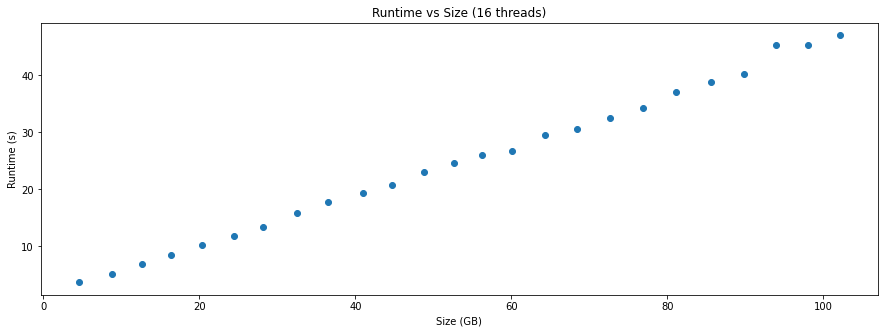

In [12]:
runtime_vs_size_plot(path, 16, 50, 2, 10)

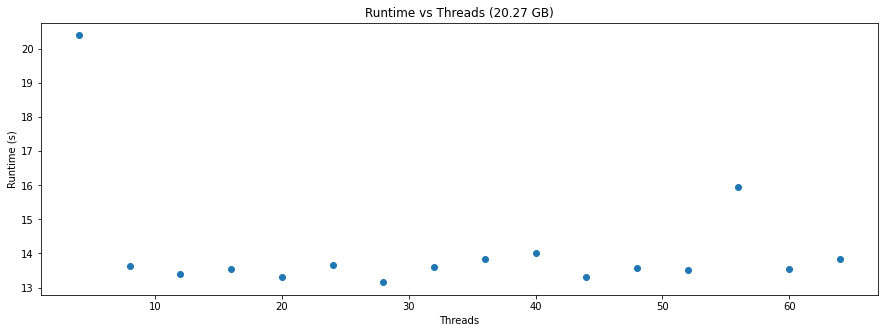

In [11]:
runtime_vs_threads_plot(path, 10, 64, 4, 10)

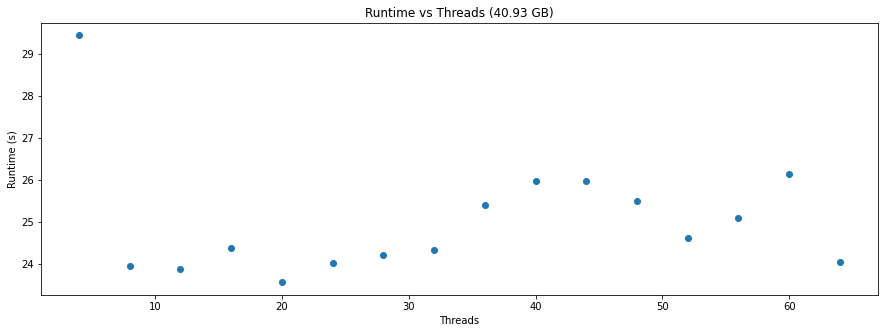

In [12]:
runtime_vs_threads_plot(path, 20, 64, 4, 10)